# Simple analysis of GB1900

TODO:

- [ ] Histogram 2D using geopandas
- [ ] Legend beautification
- [ ] local_authority labels on the maps (when hover over them)
- [ ] change basemap to exclude Northern Ireland
- [ ] query maps based on lat/lon of pins, possibly add a new column with link to sheets
- [ ] abbreviation disambiguation ---> remove dots (in search/string matching step)

In [1]:
# %matplotlib notebook 

## Read the Gazetteer (gb1900_gazetteer_complete_july_2018.csv)

In [2]:
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

In [3]:
with open("./gb1900_gazetteer_complete_july_2018.csv", encoding='UTF-16') as f:
    df = pd.read_csv(f)

/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
0,52b34d8b695fe90005004e1e,F. P.,Wales,Powys,Llansilin,320836.712742,327820.182715,52.842050,-3.176744,NaN
1,5800a6b92c66dcab3d061796,Parly. & Munl Boro. By.,England,City of London,NaN,531794.825962,180705.741898,51.509918,-0.102246,NaN
2,5800a6782c66dcab3d061786,S. Ps.,England,City of London,NaN,531736.217116,180725.027730,51.510105,-0.103083,NaN
3,57f684f42c66dcab3d01c0dd,Southwark Bridge Stairs,England,City of London,NaN,532199.584123,180696.934434,51.509744,-0.096420,NaN
4,57f685002c66dcab3d01c0e9,St. Paul's Pier,England,City of London,NaN,531987.486097,180745.664556,51.510232,-0.099456,NaN


## Find and group unique text strings

In [5]:
min_counts = 5000
xy2plot = df.groupby("final_text").count().sort_values("pin_id", ascending=False)["pin_id"]
xy2plot_filtered = xy2plot[xy2plot > min_counts]
print("Total number of unique text strings: {}".format(len(xy2plot)))
print("Number of unique text strings (after filtering): {}".format(len(xy2plot_filtered)))

Total number of unique text strings: 692648
Number of unique text strings (after filtering): 30


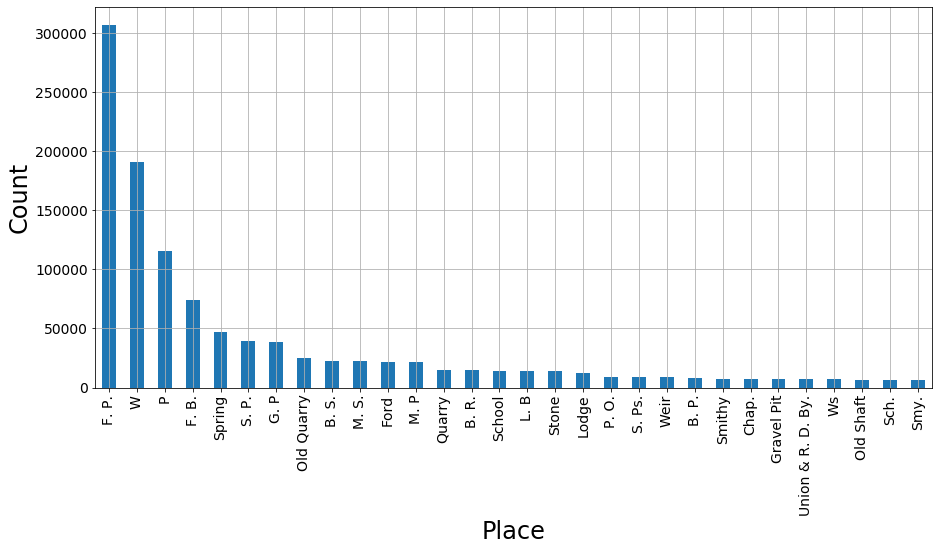

In [6]:
ax = plt.figure(figsize=(15, 7)).add_subplot(111)
xy2plot_filtered.plot(ax=ax, kind='bar')
ax.set_xlabel("Place", size=24)
ax.set_ylabel("Count", size=24)
ax.tick_params(labelsize=14)
ax.grid()
plt.show()

In [7]:
# list text/number of xy2plot_filtered
first_index = 0
last_index = 50
xy2plot_filtered[first_index:last_index]

final_text
F. P.                306583
W                    190979
P                    115877
F. B.                 74514
Spring                46876
S. P.                 39571
G. P                  38842
Old Quarry            24673
B. S.                 22363
M. S.                 22161
Ford                  21926
M. P                  21241
Quarry                15042
B. R.                 14891
School                14351
L. B                  14279
Stone                 13625
Lodge                 12661
P. O.                  9030
S. Ps.                 8841
Weir                   8840
B. P.                  8528
Smithy                 7330
Chap.                  7177
Gravel Pit             7029
Union & R. D. By.      6887
Ws                     6868
Old Shaft              6436
Sch.                   6422
Smy.                   6189
Name: pin_id, dtype: int64

In [8]:
# one instance with longitude < -10
df[df["longitude"] < -10]

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
1045410,57f2d91b2c66dcab3d005cae,Rockall,Scotland,Na H Eileanan An Iar,NaN,-296486.365838,916606.505261,57.596578,-13.688536,NaN


## Select texts/lables for further analysis/plotting

In [9]:
# read OS_Abbreviations.xlsx file which contains mapping between label and text
os_abbreviation = pd.read_excel("./OS_Abbreviations.xlsx")

search_string = "chapel"
list_of_selected_text = os_abbreviation[os_abbreviation["text"].str.contains(search_string, 
                                                                             case=False, 
                                                                             na=False)].label.to_list()
list_of_selected_text.extend([search_string])
print("Here is the list of selected texts that contain {}: {}".format(search_string, list_of_selected_text))

for itext in list_of_selected_text:
    print(10*"=" + " {}".format(itext))
    df_filtered = df[df["final_text"].str.contains(itext, case=False, na=False)]
    print(df_filtered.groupby("final_text").count().sort_values("pin_id", ascending=False)["pin_id"][0:40])

Here is the list of selected texts that contain chapel: ['Chap', 'chapel']
========== Chap
final_text
Chap.                     7177
Meth. Chap.               4810
Chapel                    2149
Methodist Chapel           805
Mort. Chap.                628
Chapel (Site of)           530
Bapt. Chap.                499
Congl. Chap.               352
Baptist Chapel             329
Mort. Chaps.               273
Meth. Chapel               257
R. C. Chap.                196
Chapel (Remains of)        180
Meth Chap                  144
R. C. Chapel               135
Chapel Hill                121
Chapel Lane                113
Independent Chapel         108
Bible Christian Chapel     107
Chapel Farm                 99
Congregational Chapel       97
Chapel (In Ruins)           96
Ebenezer Chapel             93
CHAPEL STREET               92
Chapel House                88
Mortuary Chapel             70
Congl. Chapel               70
Chaps.                      60
Meth. Chap                  60

In [10]:
#1: each text/label is treated as an individual label
#2: combine list_of_selected_text
text_method = 2

# enter selected texts here
list_of_selected_text = ["School", "Sch."]

lats2plot = []
lons2plot = []
for i in list_of_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.append(df_filtered["latitude"].tolist())
    lons2plot.append(df_filtered["longitude"].tolist())

if text_method == 2:
    lats2plot = [list(itertools.chain.from_iterable(lats2plot))]
    lons2plot = [list(itertools.chain.from_iterable(lons2plot))]
    list_of_selected_text = [", ".join(list_of_selected_text)]    

'School' has 14351 rows.
'Sch.' has 6422 rows.


## GeoPandas for plotting

In [11]:
import geopandas as gpd
from shapely.geometry import Point

# Download shapefiles from earthworks.stanford.edu
world = gpd.read_file("./data_EPSG_4326/GBR_adm0.shp")

### Plot labels separately (text_method = 1)

No handles with labels found to put in legend.


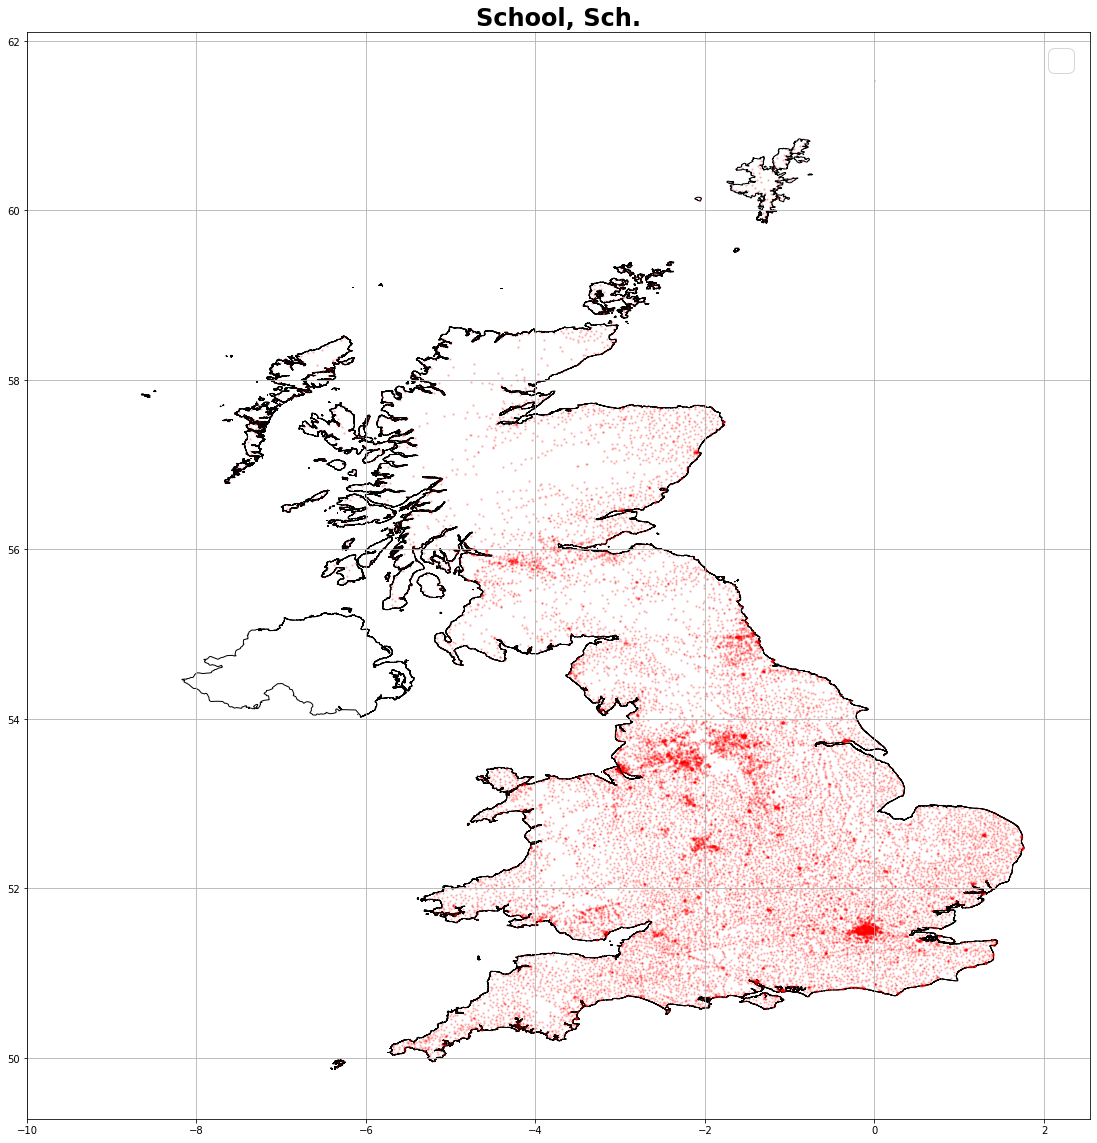

In [12]:
list_colors = ["r", "b", "g", "c", "m"]

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf.plot(ax=world.plot(figsize=(20, 20), edgecolor='k', color='none'), 
             marker='o', 
             color=list_colors[igrp], 
             markersize=2,
             alpha=0.2
            )
    plt.title(list_of_selected_text[igrp], size=24, weight='bold')
    plt.xlim(xmin=-10)
    plt.legend(prop={'size': 32})
    plt.grid()
plt.show()

### Plot labels together on one map (text_method = 1 or 2)

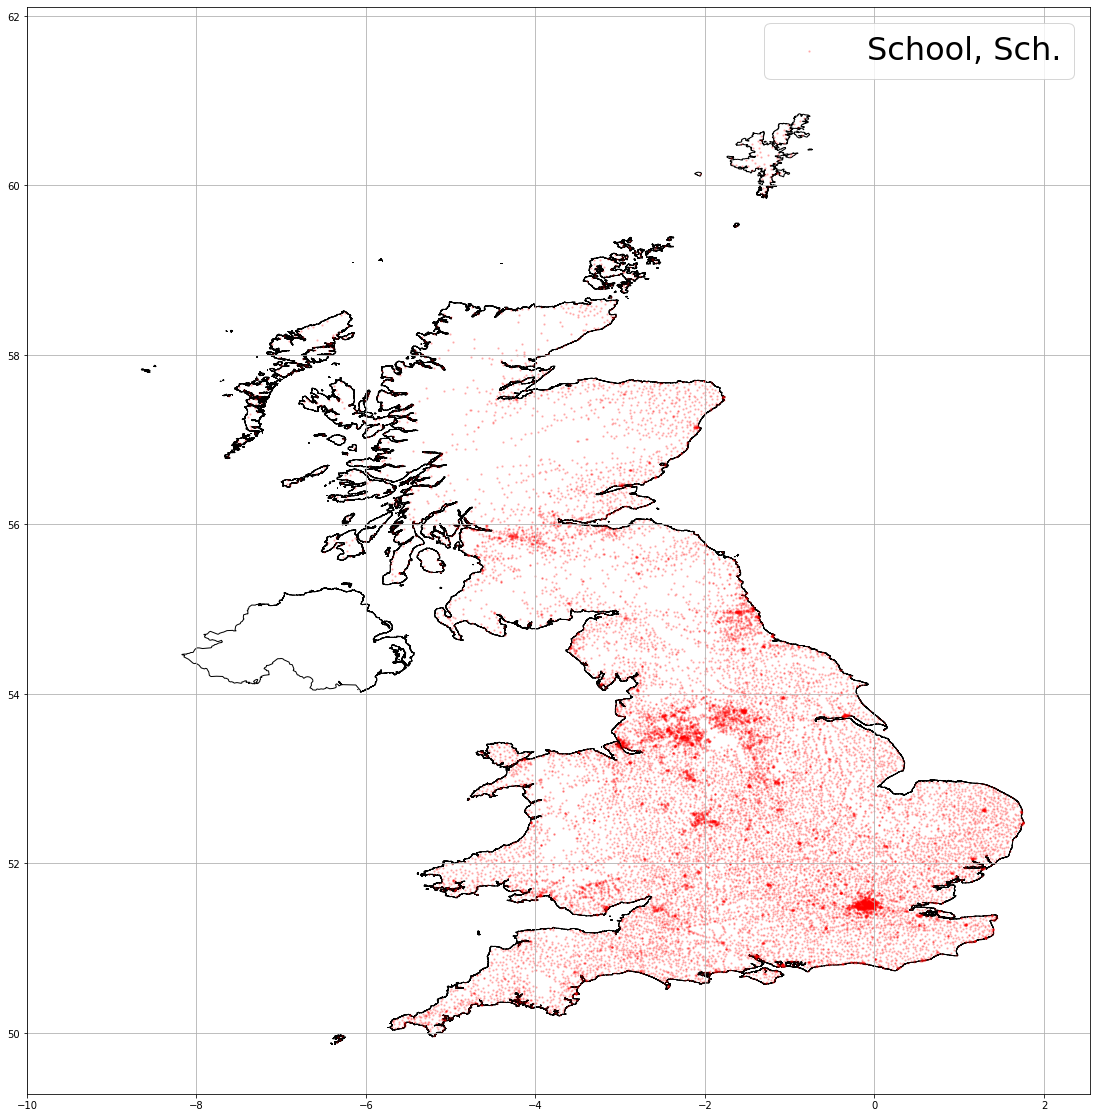

In [13]:
list_colors = ["r", "b", "g", "c", "m"]

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

world.plot(ax=ax, edgecolor='k', color='none')

for igrp in range(len(lats2plot)):
    geometry = [Point(xy) for xy in zip(lons2plot[igrp], lats2plot[igrp])]
    gdf = gpd.GeoDataFrame(geometry=geometry)
    gdf.plot(ax=ax, 
             marker='o', 
             color=list_colors[igrp], 
             markersize=2,
             label=list_of_selected_text[igrp],
             alpha=0.2
            )
plt.xlim(xmin=-10)
plt.grid()
plt.legend(prop={'size': 32})
plt.show()

### Simple plot (no projection)

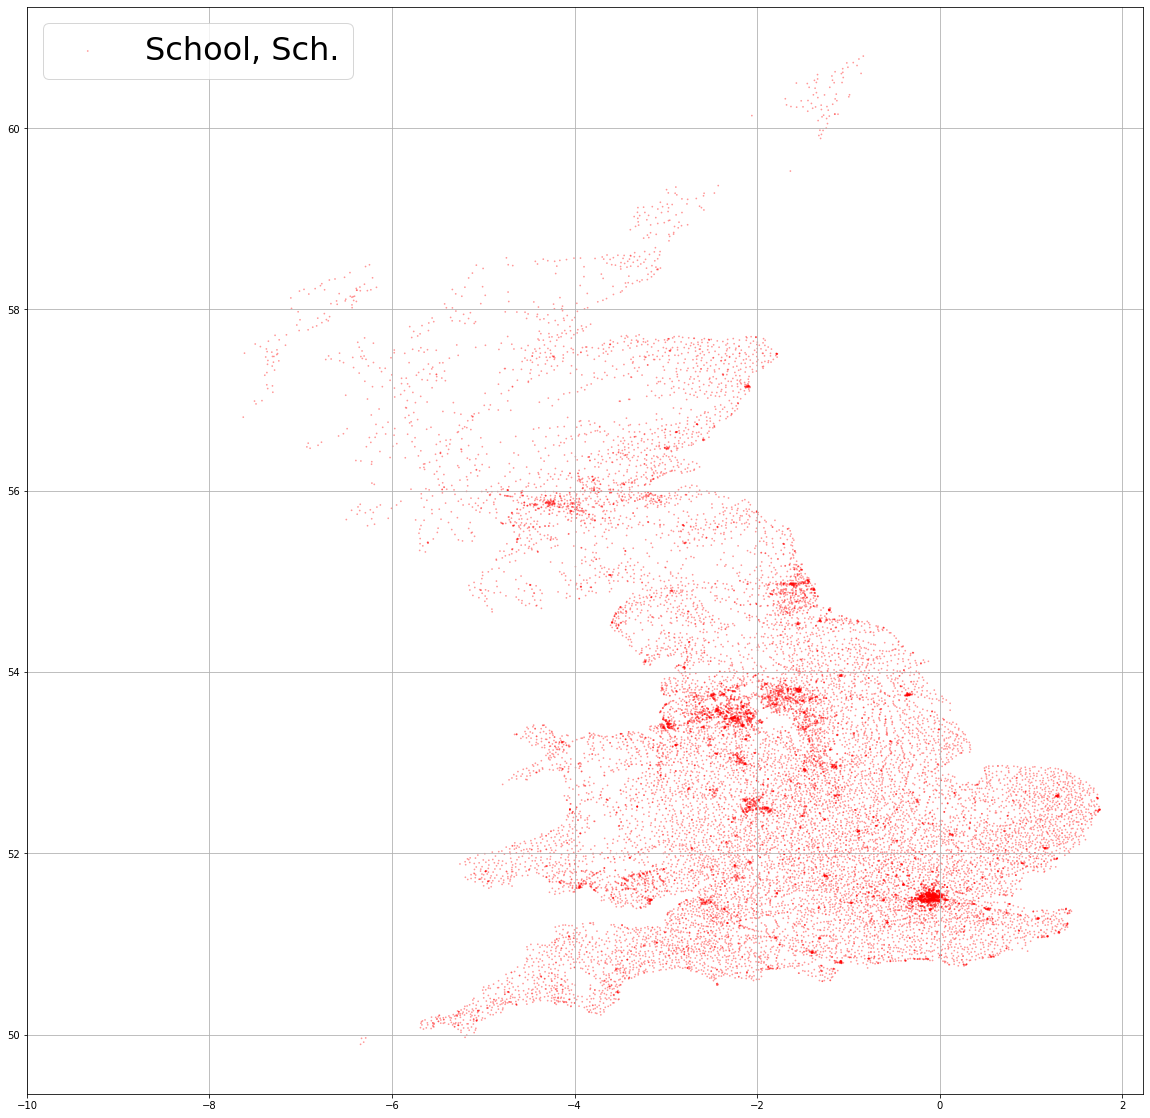

In [14]:
list_colors = ["r", "b", "g", "c", "m"]
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

for igrp in range(len(lats2plot)):
    plt.scatter(np.array(lons2plot[igrp]), 
            np.array(lats2plot[igrp]), 
            c=list_colors[igrp],
            s=3,
            edgecolors='none',
            alpha=0.4,
            label=list_of_selected_text[igrp])
    
plt.xlim(xmin=-10)
plt.grid()
plt.legend(prop={'size': 32})
plt.show()

## 2D Histograms

No handles with labels found to put in legend.


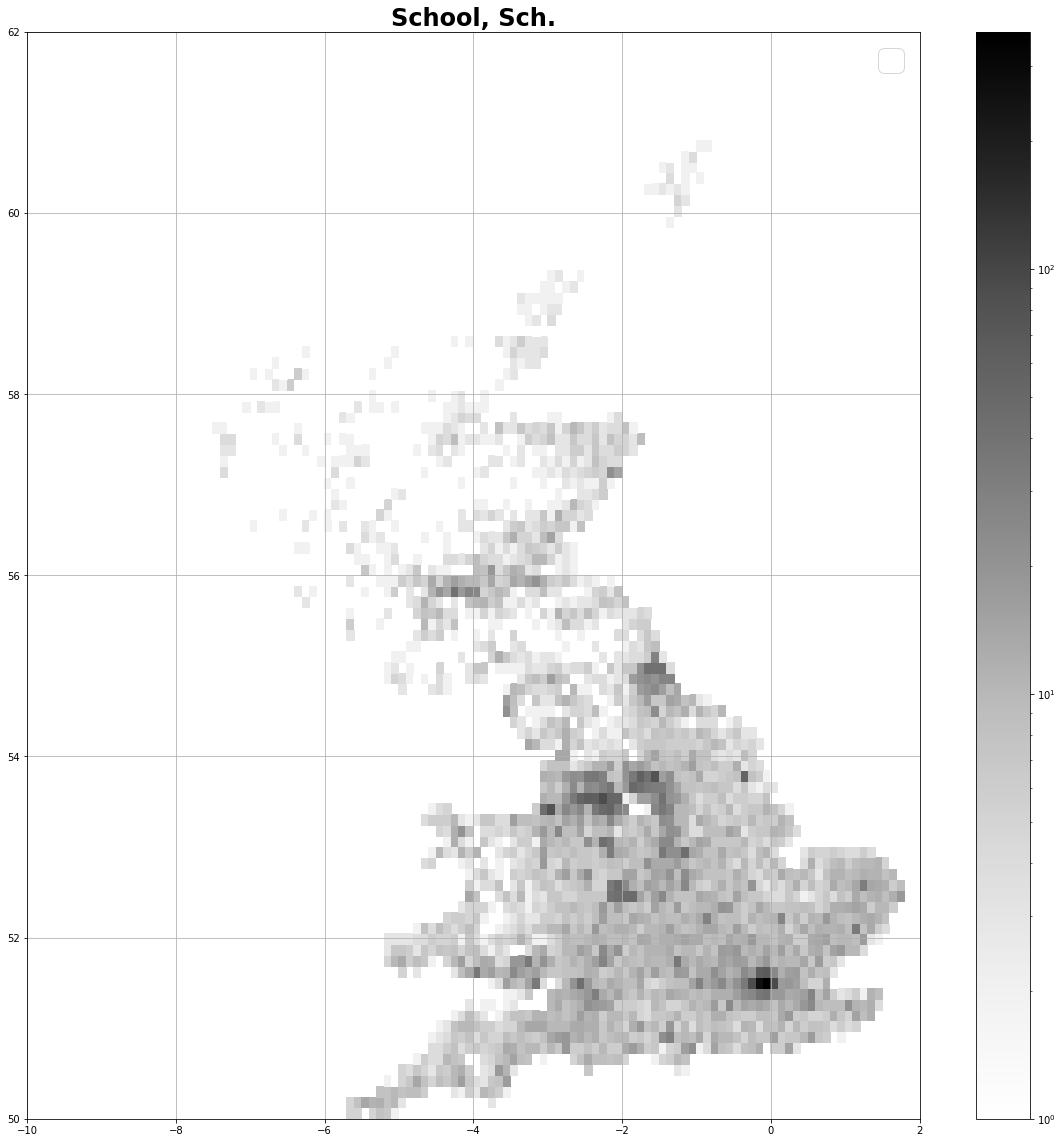

In [15]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(20, 20))

igrp = 0
plt.hist2d(np.array(lons2plot[igrp]), 
           np.array(lats2plot[igrp]),
           bins=(100, 100),
           range=[[-8, 2], [50, 62]],
           cmap="Greys",
           label=list_of_selected_text[igrp],
           #cmin=1,
           #cmax=100,
           norm=LogNorm()
          )

plt.title(list_of_selected_text[igrp], size=24, weight='bold')
plt.xlim(xmin=-10)
plt.legend(prop={'size': 32})
plt.colorbar()
plt.grid()
plt.show()

## Simple statistical analysis

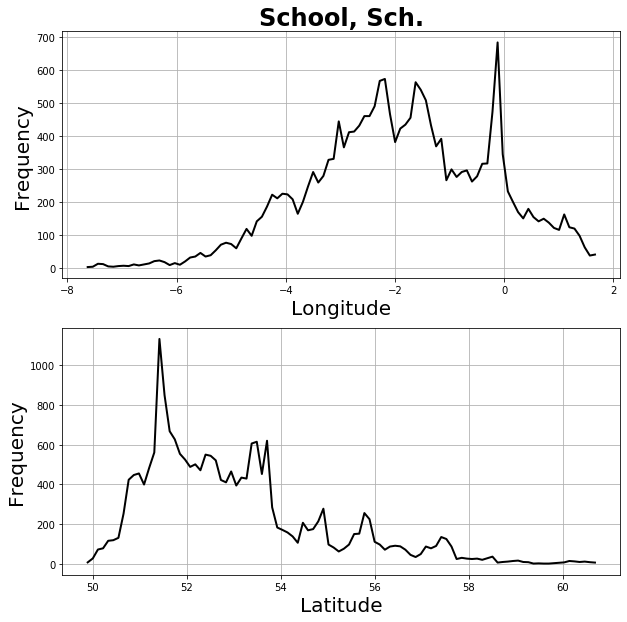

In [16]:
x_bin = 100
y_bin = 100

igrp = 0
hist_map = np.histogram2d(np.array(lons2plot[igrp]), 
                          np.array(lats2plot[igrp]), 
                          bins=(x_bin, y_bin))

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(hist_map[1][:-1], hist_map[0].sum(axis=1), lw=2, c='k')
plt.ylabel("Frequency", size=20)
plt.xlabel("Longitude", size=20)
plt.title(list_of_selected_text[igrp], size=24, weight='bold')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(hist_map[2][:-1], hist_map[0].sum(axis=0), lw=2, c='k')
plt.ylabel("Frequency", size=20)
plt.xlabel("Latitude", size=20)
plt.grid()

## Subtract two histograms

In [17]:
positive_list_selected_text = ["School", "Sch."]
negative_list_selected_text = ["Chap.", "Chapel"]
x_bin = 100
y_bin = 100

# ============ positive
lats2plot = []
lons2plot = []
for i in positive_list_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.extend(df_filtered["latitude"].tolist())
    lons2plot.extend(df_filtered["longitude"].tolist())
lats2plot = [lats2plot]
lons2plot = [lons2plot]

hist_map_positive = np.histogram2d(np.array(lons2plot[0]), np.array(lats2plot[0]), bins=(x_bin, y_bin))

# ============ negative
lats2plot = []
lons2plot = []
for i in negative_list_selected_text:
    df_filtered = df[df["final_text"].isin([i])]
    print("'{}' has {} rows.".format(i, len(df_filtered)))
    lats2plot.extend(df_filtered["latitude"].tolist())
    lons2plot.extend(df_filtered["longitude"].tolist())
lats2plot = [lats2plot]
lons2plot = [lons2plot]

hist_map_negative = np.histogram2d(np.array(lons2plot[0]), np.array(lats2plot[0]), bins=(x_bin, y_bin))

'School' has 14351 rows.
'Sch.' has 6422 rows.
'Chap.' has 7177 rows.
'Chapel' has 2149 rows.


No handles with labels found to put in legend.


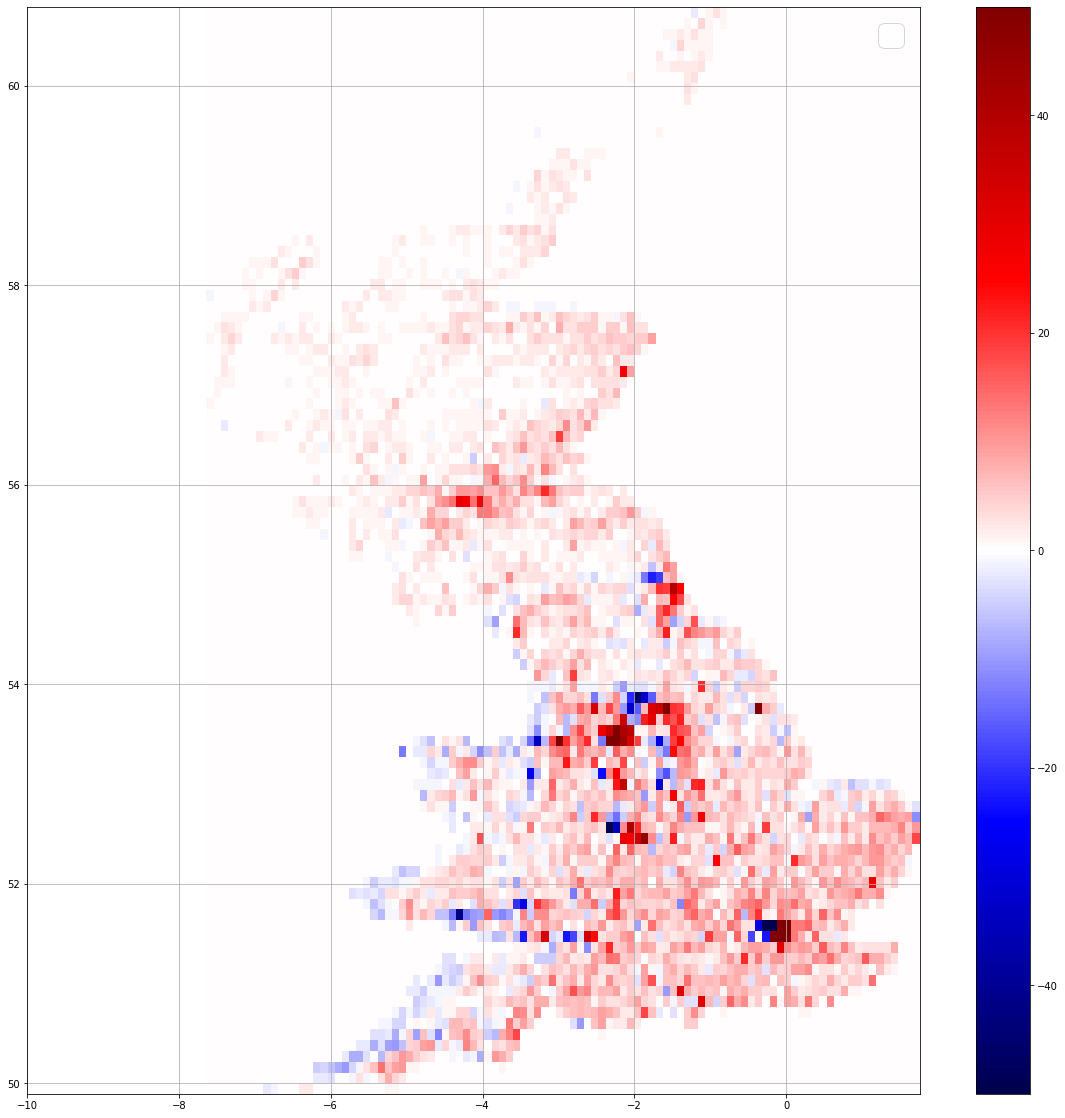

In [18]:
list_colors = ["r", "b", "g", "c", "m"]
plt.figure(figsize=(20, 20))

plt.pcolor(hist_map_positive[1], 
           hist_map_positive[2], 
           (hist_map_positive[0] - hist_map_negative[0]).T, 
           cmap="seismic",
           vmin=-50,
           vmax=50)
plt.xlim(xmin=-10)
plt.legend(prop={'size': 32})
plt.colorbar()
plt.grid()
plt.show()